<a href="https://colab.research.google.com/github/Yanina-Kutovaya/RecSys-retail/blob/main/notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1. Data ingestion

In [3]:
TRAIN_URL = 'https://storage.yandexcloud.net/recsys-retail-input/train.csv.zip'
TEST_URL = 'https://storage.yandexcloud.net/recsys-retail-input/test.csv'
ITEM_FEATURES_URL = 'https://storage.yandexcloud.net/recsys-retail-input/item_features.csv'
USER_FEATURES_URL = 'https://storage.yandexcloud.net/recsys-retail-input/user_features.csv'


data = pd.read_csv(TRAIN_URL)
test = pd.read_csv(TEST_URL)

item_features = pd.read_csv(ITEM_FEATURES_URL)
item_features.columns = map(str.lower, item_features.columns)
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)


user_features = pd.read_csv(USER_FEATURES_URL)
user_features.columns = map(str.lower, user_features.columns)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

print(f'data.shape = {data.shape}')
data.head(2)

data.shape = (2396804, 12)


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
print(f'test.shape = {test.shape}')
test.head(2)

test.shape = (88734, 12)


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0


In [5]:
print(f'item_features.shape = {item_features.shape}')
item_features.head(2)

item_features.shape = (92353, 7)


,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [6]:
print(f'user_features .shape = {user_features.shape}')
user_features.head(2)

user_features .shape = (801, 8)


,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


## 2. Data Pre-Filtering

### 2.1. Number of items in train dataset

In [7]:
data['item_id'].nunique()

89051

### 2.2. Items that have not been sold for the last 12 months

There is no need to recommend ites which have not been sold for the last 12 months

In [8]:
t = max(data['day']) - 365

not_sold_in_12_month = list(
    set(data[data['day'] < t]['item_id'].unique()) - \
    set(data[data['day'] >= t]['item_id'].unique())
)
len(not_sold_in_12_month)

20728

In [9]:
data = data[~data['item_id'].isin(not_sold_in_12_month)]
data['item_id'].nunique()

68323

### 2.3. Top popular items

There is no need to recommend top popular items - they will be bought anyway.

In [10]:
popularity = (data.groupby('item_id')['user_id'].nunique() / data['user_id'].nunique()).reset_index()
popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

top_popular = popularity[popularity['share_unique_users'] > 0.2].item_id.tolist()
len(top_popular)

125

In [11]:
data = data[~data['item_id'].isin(top_popular)]
data['item_id'].nunique()

68198

### 2.4. Top unpopular items
There is no need to recommend top unpopular items - nobody will buy them

In [12]:
top_unpopular = popularity[popularity['share_unique_users'] < 0.02].item_id.tolist()
len(top_unpopular)

61939

In [13]:
data = data[~data['item_id'].isin(top_unpopular)]
data['item_id'].nunique()

6259

### 2.5. Unpopular departments

There is no need to recommend unpopular departments

In [14]:
department_size = (
    item_features.groupby('department')['item_id'].nunique().sort_values(ascending=False)
).reset_index()
department_size.columns = ['department', 'n_items']

unpopular_departments = department_size[department_size['n_items'] < 150].department.tolist()
items_in_unpopular_departments = item_features[item_features['department'].isin(unpopular_departments)].item_id.unique().tolist()
len(items_in_unpopular_departments)

549

In [15]:
data = data[~data['item_id'].isin(items_in_unpopular_departments)]
data['item_id'].nunique()

6232

### 2.6. Price threshold
There is no need to recommend too cheap items (we will not earn on them) and too expensive ites (they will be bought irrespective of our recommendations).

In [16]:
data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))

#### 2.6.1. Cheap items

In [17]:
lower_threshold = 1
cheap_products = data.loc[data['price'] < lower_threshold, 'item_id'].unique().tolist()
len(cheap_products)

3497

In [18]:
data = data[~data['item_id'].isin(cheap_products)]
data['item_id'].nunique()

2735

#### 2.6.2. Expensive items

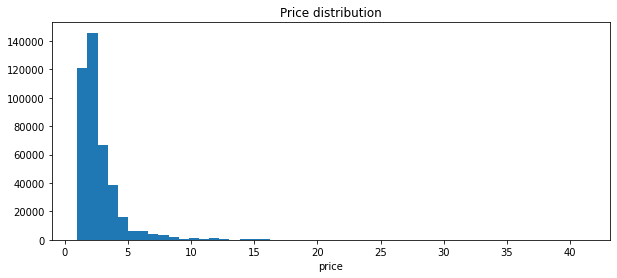

In [19]:
plt.figure(figsize=(10, 4))
plt.title('Price distribution')
plt.xlabel('price')
plt.hist(data['price'].values, bins=50);

In [20]:
upper_threshold = 30
expensive_products = data.loc[data['price'] > upper_threshold, 'item_id'].unique().tolist()
len(expensive_products)

7

In [21]:
data = data[~data['item_id'].isin(expensive_products)]
data['item_id'].nunique()

2728

### 2.7. Select top 2500 popular items

In [22]:
take_n_popular = 2500
popularity = data.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top = popularity.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()

Introduce fake item_id = 999999 (if user has bought an item which is not from top-2500, he bought an item 999999)

In [23]:
data.loc[~data['item_id'].isin(top), 'item_id'] = 999999
data['item_id'].nunique()

2501

### 2.8. Train dataset shape after pre-filtering of data

In [24]:
data.shape

(414502, 13)

## 3. Train-validation-test time split for two-stage recommender system

Train - validation - test schema:

-- old purchases -- | -- 6 weeks-- | -- 3 weeks--



In [25]:
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

t0 = data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)
t1 = data['week_no'].max() - val_lvl_2_size_weeks
t0, t1

(86, 92)

In [26]:
data_train_lvl_1 = data[data['week_no'] < t0]
data_val_lvl_1 = data[(data['week_no'] >= t0) & (data['week_no'] < t1)]

data_train_lvl_2 = data_val_lvl_1.copy() 
data_val_lvl_2 = data[data['week_no'] >= t1]

The new users on the validation and test sets

In [27]:
users_lvl_1 = data_train_lvl_1['user_id'].unique()
users_lvl_2 = data_val_lvl_1['user_id'].unique()
users_lvl_3 = data_val_lvl_2['user_id'].unique()

new_users_lvl_2 = list(set(users_lvl_2) - set(users_lvl_1))
new_users_lvl_3 = list(set(users_lvl_3) - (set(users_lvl_1) | set(users_lvl_2)))

add_to_lvl_2 = list(set(users_lvl_3) - (set(users_lvl_2)))

new_users_lvl_2, new_users_lvl_3, len(add_to_lvl_2)

([296, 1032, 1416, 1227, 1813], [1984, 1987, 1636, 2373, 2404, 2259], 165)

## 4. User features  

In [28]:
user_features['user_id'].nunique()

801

#### 4.1. Age

In [29]:
user_features.groupby('age_desc')['user_id'].count()

age_desc
19-24     46
25-34    142
35-44    194
45-54    288
55-64     59
65+       72
Name: user_id, dtype: int64

#### 4.2 Marital status

In [30]:
user_features.groupby('marital_status_code')['user_id'].count()

marital_status_code
A    340
B    117
U    344
Name: user_id, dtype: int64

#### 4.3. Income

In [31]:
user_features['income_desc'].replace(
    {'Under 15K': 10, '15-24K': 20, '25-34K':30, '35-49K': 40,
     '50-74K': 62, '75-99K': 87, '100-124K': 112, '125-149K': 137, 
     '150-174K': 162, '175-199K': 187, '200-249K': 225, '250K+':275},
     inplace=True
)
user_features.groupby('income_desc')['user_id'].count()

income_desc
10      61
20      74
30      77
40     172
62     192
87      96
112     34
137     38
162     30
187     11
225      5
275     11
Name: user_id, dtype: int64

#### 4.4. Homeowner description

In [32]:
user_features.groupby('homeowner_desc')['user_id'].count()

homeowner_desc
Homeowner          504
Probable Owner      11
Probable Renter     11
Renter              42
Unknown            233
Name: user_id, dtype: int64

#### 4.5. Household description

In [33]:
user_features.groupby('hh_comp_desc')['user_id'].count()

hh_comp_desc
1 Adult Kids         47
2 Adults Kids       187
2 Adults No Kids    255
Single Female       144
Single Male          95
Unknown              73
Name: user_id, dtype: int64

#### 4.6. Household size

In [34]:
user_features.groupby('household_size_desc')['user_id'].count()

household_size_desc
1     255
2     318
3     109
4      53
5+     66
Name: user_id, dtype: int64

#### 4.7. The number of children

In [35]:
user_features.groupby('kid_category_desc')['user_id'].count()

kid_category_desc
1               114
2                60
3+               69
None/Unknown    558
Name: user_id, dtype: int64

## 5. Item features

In [36]:
item_features['item_id'].nunique()

92353

#### 5.1. Manufacturer

In [ ]:
item_features['manufacturer'].value_counts().head(20)

69      12676
2        1411
5423     1376
764      1332
1407     1210
693       979
544       915
5143      771
1046      717
1251      685
673       682
317       669
895       642
194       641
1628      589
103       535
177       532
958       526
857       512
1075      490
Name: manufacturer, dtype: int64

#### 5.2. Department

In [37]:
department = item_features['department'].value_counts()
department[department >= 150]

GROCERY          39021
DRUG GM          31529
PRODUCE           3118
COSMETICS         3011
NUTRITION         2914
MEAT              2544
MEAT-PCKGD        2427
DELI              2354
PASTRY            2149
FLORAL             938
SEAFOOD-PCKGD      563
MISC. TRANS.       490
SPIRITS            377
SEAFOOD            369
Name: department, dtype: int64

#### 5.3. Brand

In [38]:
item_features['brand'].value_counts()

National    78537
Private     13816
Name: brand, dtype: int64

#### 5.4. Commodity description

In [39]:
item_features['commodity_desc'].value_counts().head(20)

GREETING CARDS/WRAP/PARTY SPLY    2785
CANDY - PACKAGED                  2475
MAKEUP AND TREATMENT              2467
HAIR CARE PRODUCTS                1744
SOFT DRINKS                       1704
BAG SNACKS                        1523
HISPANIC                          1460
FRZN MEAT/MEAT DINNERS            1268
STATIONERY & SCHOOL SUPPLIES      1261
MAGAZINE                          1224
BAKED BREAD/BUNS/ROLLS            1169
BOOKSTORE                         1134
BEEF                              1109
CHEESE                            1096
DOMESTIC WINE                      996
SOUP                               978
COOKIES/CONES                      951
ORAL HYGIENE PRODUCTS              913
FROZEN PIZZA                       901
CHRISTMAS  SEASONAL                866
Name: commodity_desc, dtype: int64

#### 5.5. Sub commodity description

In [40]:
item_features['sub_commodity_desc'].value_counts().head(15)

CARDS EVERYDAY                   1005
BEERALEMALT LIQUORS               833
SPICES & SEASONINGS               629
GIFT-WRAP EVERYDAY                547
POTATO CHIPS                      531
MAYBELLINE                        525
SHAMPOO                           518
COVERGIRL                         517
YOGURT NOT MULTI-PACKS            512
PREMIUM                           495
POURABLE SALAD DRESSINGS          462
CARDS SEASONAL                    456
SEASONAL CANDY BAGS-CHOCOLATE     445
NO SUBCOMMODITY DESCRIPTION       429
CANDY BAGS-CHOCOCLATE             412
Name: sub_commodity_desc, dtype: int64

#### 5.6. Size of product

In [41]:
item_features['curr_size_of_product'].value_counts().head(15)

          30607
16 OZ      3924
12 OZ      3473
8 OZ       2363
6 OZ       1697
10 OZ      1512
750 ML     1259
15 OZ      1226
24 OZ      1141
32 OZ      1011
4 OZ        967
20 OZ       939
14 OZ       903
9 OZ        894
18 OZ       771
Name: curr_size_of_product, dtype: int64

## 6. User features based on the transaction matrix

#### 6.1. Median purchase hour

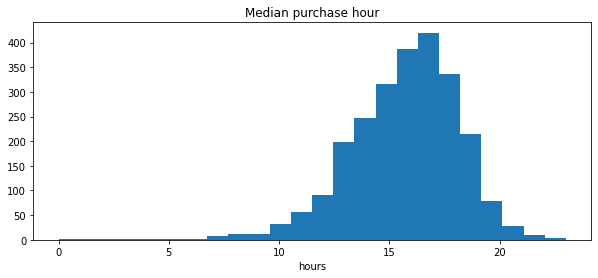

In [42]:
X = data_train_lvl_1.copy()
X['hour'] = X['trans_time'] // 100
df = X.groupby(['user_id'])['hour'].median().reset_index()

plt.figure(figsize=(10, 4))
plt.title('Median purchase hour')
plt.xlabel('hours')
plt.hist(df['hour'], bins=24);

#### 6.2. Median purchase weekday

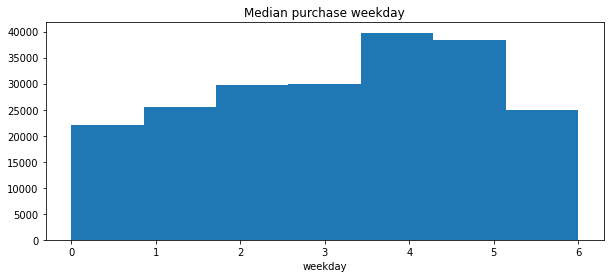

In [43]:
X['weekday'] = X['day'] % 7
df = X.groupby(['user_id', 'item_id'])['weekday'].median().reset_index()
df.columns = ['user_id', 'item_id', 'median_weekday']

plt.figure(figsize=(10, 4))
plt.title('Median purchase weekday')
plt.xlabel('weekday')
plt.hist(df['median_weekday'], bins=7);

#### 6.3. Mean number of days between purchases

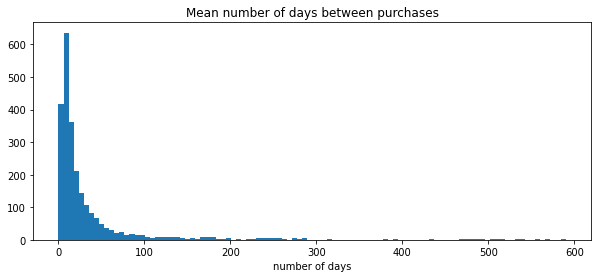

In [44]:
df = X.groupby('user_id')['day'].nunique().reset_index()
df['mean_visits_interval'] = (X.groupby('user_id')['day'].max() - X.groupby('user_id')['day'].min()) / df['day']

plt.figure(figsize=(10, 4))
plt.title('Mean number of days between purchases')
plt.xlabel('number of days')
plt.hist(df['mean_visits_interval'], bins=100);

#### 6.4. Mean basket check

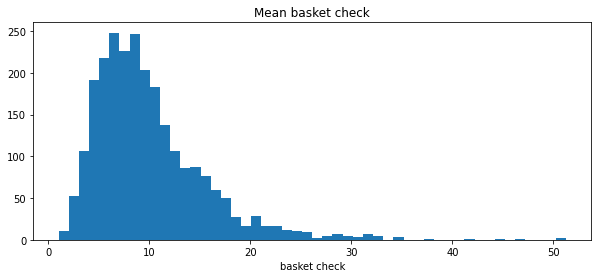

In [45]:
df = X.groupby(['user_id', 'basket_id'])['sales_value'].sum().reset_index()
df = df.groupby('user_id')['sales_value'].mean().reset_index()
df.columns = ['user_id', 'mean_check']

plt.figure(figsize=(10, 4))
plt.title('Mean basket check')
plt.xlabel('basket check')
plt.hist(df['mean_check'], bins=50);

#### 6.5. Number of stores where products were sold

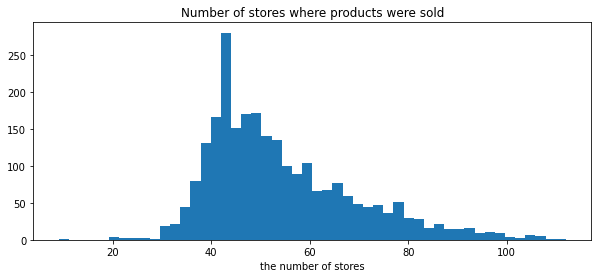

In [46]:
df = X.groupby(['item_id'])['store_id'].nunique().reset_index()
df.columns = ['item_id', 'stores']

plt.figure(figsize=(10, 4))
plt.title('Number of stores where products were sold')
plt.xlabel('the number of stores')
plt.hist(df['stores'], bins=50);

#### 6.6. The number of unique items bought by the client

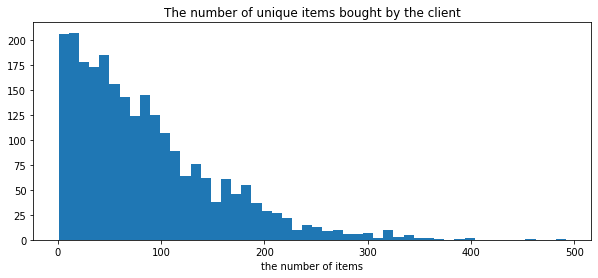

In [47]:
df = X.groupby(['user_id'])['item_id'].nunique().reset_index()
df.columns = ['user_id', 'n_items']

plt.figure(figsize=(10, 4))
plt.title('The number of unique items bought by the client')
plt.xlabel('the number of items')
plt.hist(df['n_items'], bins=50);

#### 6.7. The number of client transactions

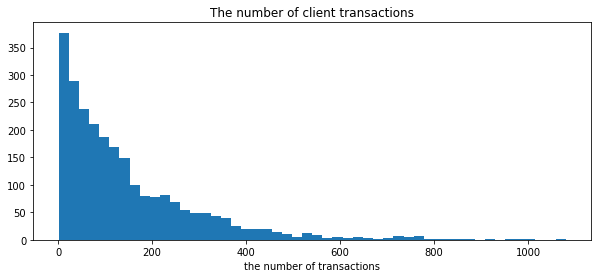

In [48]:
# кол-во транзакций клиента
df = X.groupby(['user_id'])['item_id'].count().reset_index()
df.columns = ['user_id', 'n_transactions']

plt.figure(figsize=(10, 4))
plt.title('The number of client transactions')
plt.xlabel('the number of transactions')
plt.hist(df['n_transactions'], bins=50);

#### 6.8. Mean / max / std of unique items in the client basket

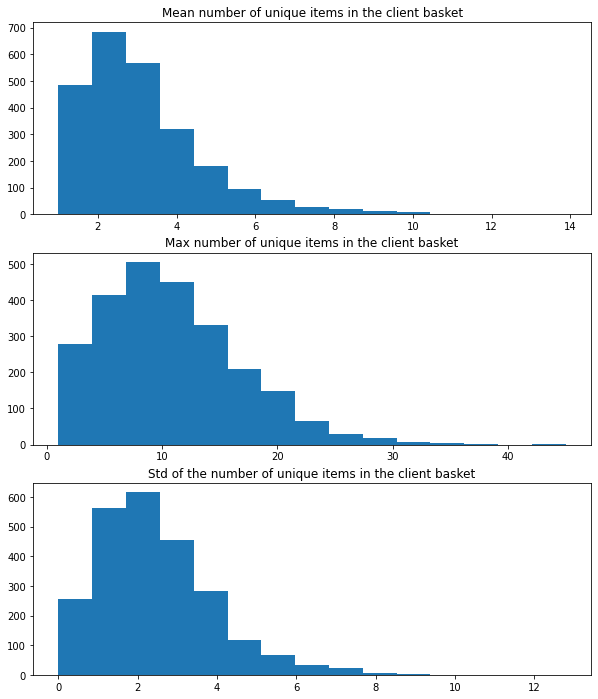

In [49]:
df = X.groupby(['user_id', 'basket_id'])['item_id'].nunique().reset_index()
df1 = df.groupby('user_id')['item_id'].mean().reset_index()
df1.columns = ['user_id', 'mean_n_items_basket']

df2 = df.groupby('user_id')['item_id'].max().reset_index()
df2.columns = ['user_id', 'max_n_items_basket']

df3 = df.groupby('user_id')['item_id'].std().reset_index()
df3.columns = ['user_id', 'std_n_items_basket']

figure, axis = plt.subplots(3, 1, figsize=(10, 12))
axis[0].hist(df1['mean_n_items_basket'], bins=15)
axis[0].set_title('Mean number of unique items in the client basket')

axis[1].hist(df2['max_n_items_basket'], bins=15);
axis[1].set_title('Max number of unique items in the client basket')

axis[2].hist(df3['std_n_items_basket'], bins=15);
axis[2].set_title('Std of the number of unique items in the client basket');

#### 6.9. Mean / max / std of unique categories in the client basket

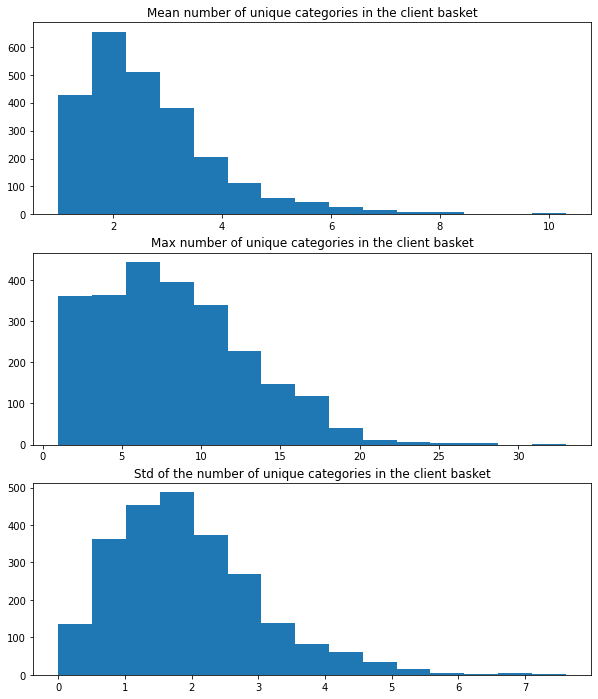

In [50]:
X = X.merge(item_features[['item_id', 'commodity_desc']], on=['item_id'])
df = X.groupby(['user_id', 'basket_id'])['commodity_desc'].nunique().reset_index()
df1 = df.groupby('user_id')['commodity_desc'].mean().reset_index()
df1.columns = ['user_id', 'mean_n_item_categories_basket']

df2 = df.groupby('user_id')['commodity_desc'].max().reset_index()
df2.columns = ['user_id', 'max_n_item_categories_basket']

df3 = df.groupby('user_id')['commodity_desc'].std().reset_index()
df3.columns = ['user_id', 'std_n_item_categories_basket']

figure, axis = plt.subplots(3, 1, figsize=(10, 12))
axis[0].hist(df1['mean_n_item_categories_basket'], bins=15)
axis[0].set_title('Mean number of unique categories in the client basket')

axis[1].hist(df2['max_n_item_categories_basket'], bins=15);
axis[1].set_title('Max number of unique categories in the client basket')

axis[2].hist(df3['std_n_item_categories_basket'], bins=15);
axis[2].set_title('Std of the number of unique categories in the client basket');